In [1]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy
from scipy.linalg import pinv
import pandas as pd

import itertools
import scipy.stats

import time

import warnings
warnings.filterwarnings('ignore')

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# import plotly.graph_objs as go

from sklearn.preprocessing import StandardScaler

# Data

In [3]:
df = pd.read_csv('data/minist_train.csv')

df_sample = df.sample(10000)

y = df_sample[df_sample.columns[0]]
X = df_sample[df_sample.columns[1:]]

# split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dimensionality Reduction

## RP

In [4]:
X_RP = GaussianRandomProjection(n_components = 6).fit_transform(X)

# RP with Clustering

In [5]:
k = 7
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit_transform(X_RP)

array([[2438.14459196, 1372.86857547, 2128.3300983 , ..., 1396.85660976,
        2253.84503515, 1154.02110261],
       [1339.66473331, 3300.66392069, 2455.87456134, ..., 2188.31001599,
        2892.30370623, 3002.63890892],
       [1843.76431695, 2125.08636486, 1804.84873625, ...,  671.96426431,
        2569.00347013, 2412.05970499],
       ...,
       [2003.02458674, 1997.87691476, 2227.34130907, ..., 1712.7051914 ,
        2081.4059298 , 2279.27252982],
       [1309.36187247, 2423.61906334, 2119.70678724, ..., 2263.0365226 ,
        1586.63709847, 2056.45591311],
       [1104.41232415, 2068.27248513, 1636.88848137, ...,  766.01355841,
        2100.78578119, 2007.75460432]])

In [6]:
X_KMeans = np.append(X_RP, k_means_clustering.fit_transform(X_RP), 1)
X_KMeans_train, X_KMeans_test, y_KMeans_train, y_KMeans_test = train_test_split(X_KMeans, y, test_size=0.3, random_state=42)

In [7]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_KMeans_train, y_KMeans_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_KMeans_test, classifier_neural_network_best.predict(X_KMeans_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 1000.0, 'hidden_layer_sizes': 20}
Time to train: 10563.126173973083
Accuracy for best neural network: 0.39866666666666667
Time to infer: 0.0049648284912109375


In [8]:
confusion_matrix(y_KMeans_test, classifier_neural_network_best.predict(X_KMeans_test))

array([[151,  14,  11,  29,   6,  14,  20,  28,  17,   1],
       [  5, 227,   7,   8,   6,  15,  24,   8,   8,  11],
       [ 25,  17,  90,  41,  30,   3,  57,  17,  23,  11],
       [ 15,   9,  16, 185,  10,   9,  21,  31,   4,  42],
       [ 30,  23,  24,  38,  69,   9,  54,  31,  16,  22],
       [ 42,  17,  22,  38,   6,  44,  20,  23,  20,  15],
       [ 33,  20,  37,  21,  24,   7, 102,  18,   6,   9],
       [ 23,  41,   2,  34,   5,   6,  14, 141,   1,  31],
       [ 37,  20,  31,  27,  14,  13,  29,  12,  90,  15],
       [ 17,  42,   3,  48,  21,   8,  17,  51,   4,  97]])

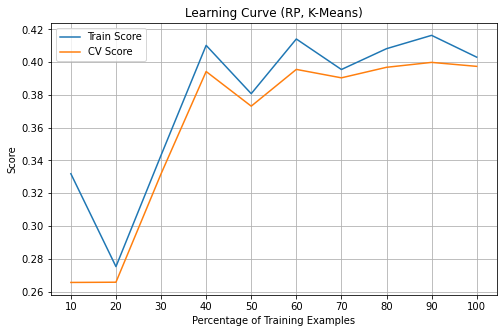

In [9]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_KMeans_train, y_KMeans_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (RP, K-Means)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_exp5_RP_learning_curve_kmeans.png')
plt.show()

## EM (GMM)

In [10]:
gmm = mixture.GaussianMixture(n_components=7, covariance_type='full')
gmm.fit(X_RP)
gmm.predict_proba(X_RP)

array([[2.42698987e-02, 8.40973878e-02, 7.66025018e-01, ...,
        3.93453418e-03, 6.82222738e-02, 3.60101266e-02],
       [2.96169053e-01, 2.52968394e-03, 1.16986367e-03, ...,
        6.46746978e-05, 7.00063846e-01, 2.64440976e-17],
       [7.07962008e-03, 1.03311670e-01, 1.11910993e-01, ...,
        3.30627964e-04, 7.77094645e-01, 2.39448488e-07],
       ...,
       [2.80081704e-01, 5.28279047e-01, 1.46667081e-01, ...,
        1.00889322e-03, 3.48943049e-02, 2.12913337e-08],
       [8.80638628e-01, 1.45770417e-02, 2.23393958e-02, ...,
        2.24032154e-02, 3.97083012e-02, 5.95212182e-08],
       [1.34107253e-01, 9.65215973e-02, 1.06044156e-01, ...,
        4.97753453e-03, 6.57517021e-01, 1.13048855e-05]])

In [11]:
X_GMM = np.append(X_RP, gmm.predict_proba(X_RP), 1)
X_GMM_train, X_GMM_test, y_GMM_train, y_GMM_test = train_test_split(X_GMM, y, test_size=0.3, random_state=42)

In [12]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_GMM_train, y_GMM_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_GMM_test, classifier_neural_network_best.predict(X_GMM_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 100.0, 'hidden_layer_sizes': 18}
Time to train: 21044.65128183365
Accuracy for best neural network: 0.4136666666666667
Time to infer: 0.008261919021606445


In [13]:
confusion_matrix(y_GMM_test, classifier_neural_network_best.predict(X_GMM_test))

array([[155,  22,  20,  13,  14,   9,  17,  16,  21,   4],
       [  6, 263,  11,   1,  10,   1,  10,  11,   4,   2],
       [ 22,  15, 117,  19,  53,   2,  38,   7,  28,  13],
       [ 26,  16,  21, 153,  42,   2,  16,  12,   7,  47],
       [ 29,  32,  29,  16, 113,   3,  45,  15,  12,  22],
       [ 44,  26,  26,  28,  11,  35,  20,  11,  30,  16],
       [ 30,  36,  53,  12,  36,   5,  83,   6,   9,   7],
       [ 26,  47,   2,  20,  29,   4,  13, 116,   0,  41],
       [ 45,  21,  44,  15,  21,   7,  19,   5,  90,  21],
       [ 17,  49,   5,  23,  28,   2,  20,  36,  12, 116]])

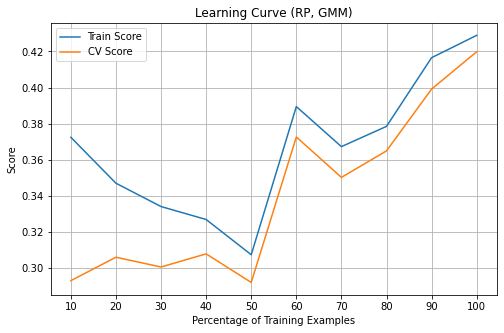

In [14]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_GMM_train, y_GMM_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (RP, GMM)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_exp5_RP_learning_curve_gmm.png')
plt.show()